# Train feedforward net

In [1]:
import src.midi_utils as midi_utils

import pygame

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
midi_filename = 'midi_data/bwv104.6.mid'
# midi_filename = 'midi_data/pkgsc_azalea.mid'
pygame.init()
pygame.mixer.music.load(midi_filename)
pygame.mixer.music.play()

In [3]:
pygame.mixer.music.stop()

# Neural network

In [101]:
from src.dataset_utils import TrackDataset, get_dataset_representation_from_tracks
from torch.utils.data import DataLoader

from sklearn.preprocessing import StandardScaler

feature_scaler = StandardScaler()
label_scaler = StandardScaler()

tracks = []
# iterate over all midi files of folder
import glob
import os

try:
    home_dir
except NameError:
    home_dir = os.getcwd()

os.chdir(home_dir + "/midi_data/bach")  # go to a folder relative to home dir
for midi_file in glob.glob("*.mid"):
    # get a list of all soprano tracks
    ## load midi file
    csv_text = midi_utils.load_to_csv(midi_file)

    ## Split into tracks
    track_dict = midi_utils.split_tracks(csv_text)
    track_nr = '1'

    ## Generating numpy array with notes
    track = midi_utils.midi_track_to_numpy(track_dict[track_nr])
    tracks.append(track)
    
print("Number of tracks: " + str(len(tracks)))

x, y = get_dataset_representation_from_tracks(tracks, feature_qty=20, prediction_qty=2)

x = np.stack(x)
x = x[:,:,0]

y = np.stack(y)
y = y[:,:,0]

feature_scaler.fit(x)

print("Mean of the dataset: " + str(feature_scaler.mean_))

x = feature_scaler.fit_transform(x)

label_scaler.fit(y)

y = label_scaler.fit_transform(y)


print("Number of samples: " + str(len(x)))

mini_batch_size = 32

# for now, we only train on the pitches of the notes
train_dataset = TrackDataset(x, y, drop_length=False)  # make training dataset
#validation_dataset = TrackDataset(val_images, val_centers)  # make validation dataset
#test_dataset = TrackDataset(test_images, test_centers)  # make test dataset

train_loader = DataLoader(train_dataset, batch_size=mini_batch_size, shuffle=True)
validation_loader = DataLoader(train_dataset, batch_size=mini_batch_size, shuffle=True) # TODO TODO TODO: CHANGE TO A SUITABLE VALIDATIONSET
#test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

Number of tracks: 357
Mean of the dataset: [70.56518792 70.62664759 70.66822324 70.69465994 70.71220908 70.71168186
 70.70527981 70.69315357 70.68999021 70.68727875 70.67831588 70.66302629
 70.64992092 70.63568577 70.63478195 70.64261505 70.65157792 70.66159524
 70.67432402 70.67567975]
Number of samples: 13277


c:\users\i0325777\appdata\local\continuum\miniconda3\envs\tensorflow-base\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\users\i0325777\appdata\local\continuum\miniconda3\envs\tensorflow-base\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\users\i0325777\appdata\local\continuum\miniconda3\envs\tensorflow-base\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\users\i0325777\appdata\local\continuum\miniconda3\envs\tensorflow-base\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by Stan

In [102]:
import torch
import torch.nn as nn
import numpy as np

print("Training set size", len(train_dataset))

input_size = len(train_dataset[0][0])  # get input size
input_example = train_dataset[0][0]
output_size = len(train_dataset[0][1])  # get output size
output_example = train_dataset[0][1]
learning_rate = 0.001

print("Input size {}/ output size {}/ learning rate {}".format(input_size, output_size, learning_rate))
print("Input example {}".format(input_example))
print("Output example {}".format(output_example))


class LinearModel(nn.Module):

    def __init__(self, input_dimension, output_dimension):
        super(LinearModel, self).__init__()
        self.fc = torch.nn.Linear(input_dimension, output_dimension, bias=True)  # linear layer with parameters A, b

    def forward(self, input_data):
        output = self.fc(input_data)  # applies out = input * A + b. A, b are parameters of nn.Linear that we want to learn
        return output
    

class MLPModel(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, input):
        return self.layers(input)
    
device = torch.device('cpu')
    
# linear_model = LinearModel(input_size, output_size)
# 
# linear_model = linear_model.to(device)
# 
mlp_model = MLPModel(input_size, 256, output_size)

mlp_model = mlp_model.to(device)

model = mlp_model


criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


def train(model, train_dataloader, val_dataloader, optimizer, n_epochs, loss_function, device=torch.device('cpu'), verbose=1):
    # We will monitor loss functions as the training progresses
    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        # training phase
        model.train()
        # Iterate mini batches over training dataset
        losses = []
        for x, y in train_dataloader:
            x = x.to(device)
            y = y.to(device)
            output = model(x)  # predict output from input
            
            # set gradients to zero
            optimizer.zero_grad()

            loss = loss_function(output, y)
            if verbose > 2:
                print(loss.item())
            loss.backward()
            optimizer.step()

            # Metrics
            losses.append(loss.item())
            
        train_losses.append(np.mean(np.array(losses)))

        # Evaluation phase
        model.eval()
        # iterate mini batches over validation set
        # We don't need gradients
        losses = []
        with torch.no_grad():
            for x, y in val_dataloader:
                x = x.to(device)
                y = y.to(device)
                output = model(x)
                loss = loss_function(output, y)
                if verbose > 1:
                    print(loss.item())

                losses.append(loss.item())
        val_losses.append(np.mean(np.array(losses)))
        
        if verbose > 0:
            print('Epoch {}/{}: train_loss: {:.4f}, val_loss: {:.4f}'.format(epoch + 1, n_epochs, train_losses[-1], val_losses[-1]))
    return train_losses, val_losses


Training set size 13277
Input size 20/ output size 2/ learning rate 0.001
Input example tensor([ 0.9796,  1.8240,  0.9512,  0.9406,  0.9328,  0.9315,  1.2167,  0.9348,
         0.3699,  0.3700, -0.1906,  0.9375,  1.7837,  0.3825,  0.3826,  0.3806,
        -1.0221, -0.1851, -0.4686, -1.0288])
Output example tensor([0.9344, 1.7809])


In [103]:
# Train the linear model and plot how the loss changes as the 
# training progresses for both training and validation set.
import matplotlib.pyplot as plt
%matplotlib inline

train_losses, val_losses = train(model, train_loader, validation_loader, optimizer, 50, criterion, verbose=1)

Epoch 1/50: train_loss: 0.5319, val_loss: 0.4928
Epoch 2/50: train_loss: 0.5008, val_loss: 0.4972
Epoch 3/50: train_loss: 0.4897, val_loss: 0.4674
Epoch 4/50: train_loss: 0.4764, val_loss: 0.4611
Epoch 5/50: train_loss: 0.4648, val_loss: 0.4411
Epoch 6/50: train_loss: 0.4531, val_loss: 0.4305
Epoch 7/50: train_loss: 0.4362, val_loss: 0.4183
Epoch 8/50: train_loss: 0.4197, val_loss: 0.3853
Epoch 9/50: train_loss: 0.4052, val_loss: 0.3719
Epoch 10/50: train_loss: 0.3848, val_loss: 0.3476
Epoch 11/50: train_loss: 0.3621, val_loss: 0.3314
Epoch 12/50: train_loss: 0.3476, val_loss: 0.3133
Epoch 13/50: train_loss: 0.3268, val_loss: 0.2837
Epoch 14/50: train_loss: 0.3047, val_loss: 0.2701
Epoch 15/50: train_loss: 0.2835, val_loss: 0.2525
Epoch 16/50: train_loss: 0.2665, val_loss: 0.2326
Epoch 17/50: train_loss: 0.2459, val_loss: 0.2218
Epoch 18/50: train_loss: 0.2305, val_loss: 0.1945
Epoch 19/50: train_loss: 0.2141, val_loss: 0.1892
Epoch 20/50: train_loss: 0.1983, val_loss: 0.1766
Epoch 21/

[[74. 76. 74. 77.]
 [72. 70. 72. 71.]
 [69. 74. 69. 74.]
 [70. 69. 70. 69.]
 [75. 75. 76. 75.]
 [76. 77. 75. 75.]
 [73. 66. 73. 66.]
 [74. 69. 74. 68.]
 [75. 77. 75. 77.]
 [67. 74. 67. 73.]
 [73. 74. 73. 74.]
 [66. 64. 66. 64.]
 [72. 71. 72. 72.]
 [71. 69. 71. 70.]
 [67. 72. 67. 70.]
 [68. 69. 69. 69.]
 [75. 75. 74. 74.]
 [71. 71. 71. 71.]
 [77. 76. 77. 75.]
 [73. 74. 73. 75.]
 [74. 72. 73. 72.]
 [74. 72. 73. 72.]
 [70. 72. 69. 73.]
 [66. 64. 67. 66.]
 [73. 69. 72. 70.]
 [69. 70. 69. 70.]
 [73. 71. 74. 71.]
 [70. 69. 69. 69.]
 [71. 69. 71. 69.]
 [74. 75. 74. 75.]
 [69. 69. 68. 69.]
 [67. 69. 67. 70.]]


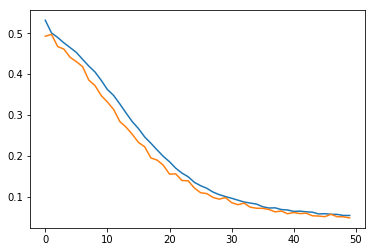

In [104]:
# check predictions from samples

model.eval()

for x, y in train_loader:
    x = x.to(device)
    y = y.to(device)
    output = model(x)  # predict output from input
    
    scaled_y = label_scaler.inverse_transform(y.detach().numpy())
    scaled_output = label_scaler.inverse_transform(output.detach().numpy())

    print(np.concatenate((scaled_y, np.round(scaled_output)), axis=1))
    break


plt.axis('on')
x = range(len(train_losses))
plt.plot(x, train_losses, x, val_losses)

plt.show()

In [123]:
# predict midi from init samples

init_index = 1000

generated_track = train_dataset[init_index][0].clone()

# predict for a certain length
predict_length = 30  # TODO: Model the end of the songs as well through a terminator.

x, y = train_dataset[init_index]
x = x.to(device)
for i in range(predict_length):
    _, y = train_dataset[init_index + i]
    y = y.to(device)
    output = model(x)  # predict output from input
    x = torch.cat((x[output.shape[0]:], output))  # shift the input by one by adding the prediction
    generated_track = torch.cat((generated_track, output))  # append prediction to generated track
    
#print(generated_track.detach().numpy())
    
n_generated_track = generated_track.detach().numpy()
n_generated_track = n_generated_track.reshape(int(n_generated_track.shape[0]/output.shape[0]), output.shape[0])
track = label_scaler.inverse_transform(n_generated_track).round().flatten()

print(track)


[72. 70. 72. 74. 72. 70. 69. 70. 72. 70. 69. 67. 67. 72. 71. 72. 74. 72.
 70. 69. 67. 65. 65. 70. 72. 74. 71. 70. 69. 68. 70. 69. 67. 70. 72. 71.
 70. 69. 67. 68. 67. 68. 69. 70. 69. 70. 71. 69. 68. 68. 68. 68. 69. 68.
 69. 70. 70. 70. 69. 67. 67. 70. 71. 72. 71. 69. 68. 69. 69. 70. 69. 68.
 69. 69. 70. 72. 72. 71. 69. 68.]


In [124]:
# write numpy to midi track

numpy_notes = midi_utils.prediction_to_numpy(track, 1024)

# create midi track
new_track = midi_utils.numpy_to_midi_track(numpy_notes, 1, 'Modified')

#print(numpy_notes)

os.chdir(home_dir)

# make new song with the new track
new_track_dict = {}
new_track_dict['0'] = track_dict['0']
new_track_dict['1'] = new_track
modified_midi_filename = 'midi_data/test_modified_track.mid'
modified_csv_list = midi_utils.track_dict_to_csv(new_track_dict)
midi_utils.write_to_midi(modified_csv_list, modified_midi_filename)

In [125]:
pygame.init()
pygame.mixer.music.load(modified_midi_filename)
pygame.mixer.music.play()

In [88]:
pygame.mixer.music.stop()